In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from datetime import datetime

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objs as go

In [5]:
def data_filter(dat):
    dat = dat[['date' , 'open' , 'high', 'low' , 'close' , 'volume']]
    
    def ss(x):
        return datetime.strptime(x,"%Y-%m-%d %H:%M:%S+05:30").strftime("%Y-%m-%d %H:%M:%S")

    dat["date"]=list(map(ss,dat["date"]))
    
    dat['date'] = pd.to_datetime(dat['date']) # converting the date column to datetime format

    dat = dat[dat['date'] > '2017-12-31' ]
    dat = dat[dat['date'] < '2021-08-01' ]
    
    return dat

In [6]:
df = pd.read_csv('ACC_minute_data_with_indicators.csv')

In [7]:
dat = data_filter(df)

In [92]:
def resample_to_constant_volume_flex(data):
    def volumeSum_threshold():
        cumsum = 0
        val = yield cumsum
        while True:
            if cumsum < val[1]:
                cumsum += val[0]
                val = yield cumsum
            else:
                cumsum = val[0]
                val = yield cumsum
    a = volumeSum_threshold()
    next(a)
    data["volume_per_candle"] = data["volume"].rolling(window=3600).mean().rolling(window = 3000).quantile(0.999)
    data["volume_per_candle"].fillna(method="bfill",inplace=True)
    data["cumsum"] = data["volume"].cumsum()

    data["volume_vol"] = [a.send(v) for v in np.array(data[["volume","volume_per_candle"]])]
    
    data["thesholdBreak"] = data['volume_vol']>data["volume_per_candle"]
    
    data["close_vol"] = data["close"]*data["thesholdBreak"].astype(int)
    data["open_vol"] = data["open"]*((data["thesholdBreak"]).astype(int).shift(1))
    data["open_vol"].iloc[0] = data["open"].iloc[0]
    data["open_vol"] = data['open_vol'].where(data["open_vol"] != 0, np.nan)
    data["open_vol"].fillna(method="ffill",inplace=True)
    data["close_vol"] = data['close_vol'].where(data["close_vol"] != 0, np.nan)
    data["close_vol"].iloc[-1] = data['close'].iloc[-1]
    data["close_vol"].fillna(method="bfill",inplace=True)
    
    def high_():
        hh = 0
        val = yield hh
        while True:
            if val[0]:
                hh = max(hh,val[1])
                val = yield hh
                hh = 0
            else:
                hh = max(hh,val[1])
                val = yield hh
    h = high_()
    next(h)
    def low_():
        ll = np.inf
        val = yield ll
        while True:
            if val[0]:
                ll = min(ll,val[1])
                val = yield ll
                ll = np.inf
            else:
                ll = min(ll,val[1])
                val = yield ll
    l = low_()
    next(l)
    
    data["high_vol"]=[h.send(v) for v in np.array(data[["thesholdBreak","high"]])]
    data["low_vol"] =[l.send(v) for v in np.array(data[["thesholdBreak","low"]])]
    data["open"] = data["open_vol"]
    data["high"] = data["high_vol"]
    data["low"] = data["low_vol"]
    data["close"] = data["close_vol"]
    data["volume"] = data["volume_vol"]
    
    
    return data[["date","open","high","low","close","volume_per_candle","volume","thesholdBreak"]]

In [93]:
df_vol = resample_to_constant_volume_flex(dat.copy())


In [94]:
# df_vol["upper"] = np.array(df_1min_ind_date["upper"])
# df_vol['lower'] = np.array(df_1min_ind_date["lower"])
df_vol =df_vol[df_vol["thesholdBreak"]]

In [95]:
df_vol

,date,open,high,low,close,volume_per_candle,volume,thesholdBreak
249972,2018-01-01 09:16:00,1763.90,1763.90,1758.65,1763.80,996.790345,1127.0,True
249974,2018-01-01 09:18:00,1763.45,1763.45,1759.35,1759.35,996.790345,1932.0,True
249976,2018-01-01 09:20:00,1759.35,1761.00,1758.50,1758.50,996.790345,1027.0,True
249978,2018-01-01 09:22:00,1758.50,1759.45,1756.00,1758.00,996.790345,1521.0,True
249980,2018-01-01 09:24:00,1758.00,1758.00,1754.60,1754.80,996.790345,1035.0,True
...,...,...,...,...,...,...,...,...
554663,2021-07-28 15:18:00,2395.00,2397.00,2394.25,2396.95,4266.070285,4647.0,True
554665,2021-07-28 15:20:00,2396.95,2397.00,2393.10,2394.45,4266.070285,4987.0,True
554666,2021-07-28 15:21:00,2395.00,2397.10,2393.35,2394.70,4266.070285,7102.0,True
554670,2021-07-28 15:25:00,2394.70,2396.75,2390.15,2391.70,4266.070285,6238.0,True


In [96]:
def aosum(data):
    
    data["mid"] = (data["high"]+data["low"])/2
    data["ao"] = data["mid"].rolling(window = 5).mean() - data["mid"].rolling(window = 34).mean()
    data["signals1"] = ((data["ao"].shift(4))> (data["ao"].shift(3))) & ((data["ao"].shift(3))> (data["ao"].shift(2))) & ((data["ao"].shift(2)) < data["ao"].shift(1)) 
#     data["signals2"] = ((-data["ao"].shift(4))< (-data["ao"].shift(3))) & (-(data["ao"].shift(3))< (-data["ao"].shift(2))) & (-(data["ao"].shift(2)) > -data["ao"]) &(data["ao"]>0)
    data["signal"] = data["signals1"] 
    return data

In [97]:
def onlyAO(data):
    data["mid"] = (data["high"]+data["low"])/2
    data["ao"] = data["mid"].rolling(window = 5).mean() - data["mid"].rolling(window = 34).mean()
    data["pos"] = np.where(((data["ao"].shift(4))> (data["ao"].shift(3))) & ((data["ao"].shift(3))> (data["ao"].shift(2))) & ((data["ao"].shift(2)) < data["ao"].shift(1)) , 1, np.nan) 
    data['pos'] = np.where(((data["ao"].shift(4))< (data["ao"].shift(3))) & ((data["ao"].shift(3))> (data["ao"].shift(2))) & ((data["ao"].shift(2)) > data["ao"].shift(1)) , 0, data['pos']) 
    return data

In [98]:
df_vol = onlyAO(df_vol)
df_vol[df_vol['pos'] ==1]

,date,open,high,low,close,volume_per_candle,volume,thesholdBreak,mid,ao,pos
250175,2018-01-01 12:39:00,1750.10,1752.00,1750.00,1751.20,996.790345,1351.0,True,1751.000,-1.062353,1.0
250264,2018-01-01 14:08:00,1745.00,1746.10,1745.00,1745.00,996.790345,1066.0,True,1745.550,-3.998824,1.0
250332,2018-01-01 15:16:00,1735.55,1735.95,1732.05,1732.80,996.790345,1392.0,True,1734.000,-11.703235,1.0
250363,2018-01-02 09:32:00,1744.00,1744.45,1738.30,1738.30,996.790345,1556.0,True,1741.375,2.621912,1.0
250374,2018-01-02 09:43:00,1739.80,1740.20,1738.55,1740.00,996.790345,3619.0,True,1739.375,2.894118,1.0
...,...,...,...,...,...,...,...,...,...,...,...
554315,2021-07-28 09:30:00,2360.70,2363.70,2359.00,2363.70,4239.227364,5129.0,True,2361.350,-8.478088,1.0
554360,2021-07-28 10:15:00,2355.50,2356.65,2352.00,2353.25,4251.270224,4367.0,True,2354.325,-7.534265,1.0
554399,2021-07-28 10:54:00,2338.60,2341.70,2336.20,2339.95,4266.070285,5019.0,True,2338.950,-17.367941,1.0
554584,2021-07-28 13:59:00,2367.00,2380.45,2367.00,2378.75,4266.070285,8369.0,True,2373.725,12.943824,1.0


In [99]:
# df_vol['pos'] = df_vol['pos'].shift(1)

In [100]:
df_vol

,date,open,high,low,close,volume_per_candle,volume,thesholdBreak,mid,ao,pos
249972,2018-01-01 09:16:00,1763.90,1763.90,1758.65,1763.80,996.790345,1127.0,True,1761.275,NaN,NaN
249974,2018-01-01 09:18:00,1763.45,1763.45,1759.35,1759.35,996.790345,1932.0,True,1761.400,NaN,NaN
249976,2018-01-01 09:20:00,1759.35,1761.00,1758.50,1758.50,996.790345,1027.0,True,1759.750,NaN,NaN
249978,2018-01-01 09:22:00,1758.50,1759.45,1756.00,1758.00,996.790345,1521.0,True,1757.725,NaN,NaN
249980,2018-01-01 09:24:00,1758.00,1758.00,1754.60,1754.80,996.790345,1035.0,True,1756.300,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
554663,2021-07-28 15:18:00,2395.00,2397.00,2394.25,2396.95,4266.070285,4647.0,True,2395.625,14.519118,NaN
554665,2021-07-28 15:20:00,2396.95,2397.00,2393.10,2394.45,4266.070285,4987.0,True,2395.050,14.190294,NaN
554666,2021-07-28 15:21:00,2395.00,2397.10,2393.35,2394.70,4266.070285,7102.0,True,2395.225,13.800735,NaN
554670,2021-07-28 15:25:00,2394.70,2396.75,2390.15,2391.70,4266.070285,6238.0,True,2393.450,13.071029,NaN


In [101]:
df_vol['pos'].fillna(method = "ffill",inplace = True)

In [102]:
# df_vol[]

In [103]:
# df_vol['>lower'] = df_vol['close']<df_vol['lower']

In [104]:
# df_vol['>lower']

In [105]:
# df_vol['position'] = df_vol['>lower']*df_vol['signal1']
# df_vol['position'] = df_vol['position'].shift()

In [106]:
df_vol['return'] = df_vol['close'].pct_change()

In [107]:
df_vol['strat_return'] = df_vol['pos']*df_vol['return']

In [108]:
df_vol['strat_return1'] = 1 + df_vol['strat_return']
df_vol['cc_return1'] = 1 + df_vol['return']

In [109]:
df_vol['stat_ret'] = df_vol['strat_return1'].cumprod()

In [110]:
df_vol['cc_ret'] = df_vol['cc_return1'].cumprod()

<AxesSubplot:>

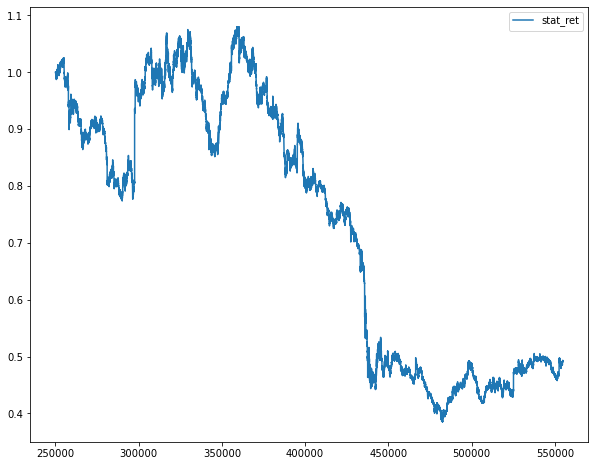

In [111]:
df_vol[['stat_ret']].plot(figsize = (10,8))

In [112]:
def plot(df3):
    
    # Create the candlestick chart
    candlestick = go.Candlestick(x=df3.index, open=df3['open'], close=df3['close'], high=df3['high'], low=df3['low'])

    # Add a line plot with secondary x-axis
    #line = go.Scatter(x=df3['date'], y=df3['close'], name='date', xaxis='x2')
    #line = go.Bar(x=df3.index, y=df3['volume'], name='Volume')

    # Create the figure with both the candlestick and line plots
    fig = go.Figure(data=[candlestick])

    # Update the layout to add a secondary x-axis
#     fig.update_layout(xaxis2=dict(title='volume', overlaying='x', side='top'),yaxis2 = dict(title='volume', overlaying='y', side='top'))
    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()
    
    fig.add_bar(x=df3.index, y=df3['ao'], name='AO', yaxis='y3')

# Update the layout to add a third y-axis for AO
    fig.update_layout(yaxis3=dict(title='AO', side='right'))

    # Show the chart
    fig.show()

In [113]:
# df_vol = df_vol.reset_index()
len(df_vol)

128943

In [114]:
check_df = df_vol.iloc[ 10095:10120]
plot(check_df)


In [49]:
df_vol.head(60).tail(10)

,date,open,high,low,close,volume_per_candle,volume,thesholdBreak,mid,ao,pos,return,strat_return,strat_return1,cc_return1,stat_ret,cc_ret
250096,2018-01-01 11:20:00,1750.00,1751.65,1750.00,1751.60,632.781667,638.0,True,1750.825,1.761176,0.0,0.000914,0.000000,1.000000,1.000914,1.000000,0.995227
250098,2018-01-01 11:22:00,1751.60,1753.85,1751.00,1753.85,632.781667,1236.0,True,1752.425,2.016471,0.0,0.001285,0.000000,1.000000,1.001285,1.000000,0.996506
250100,2018-01-01 11:24:00,1753.85,1754.80,1753.65,1753.75,632.781667,1331.0,True,1754.225,2.686765,1.0,-0.000057,-0.000057,0.999943,0.999943,0.999943,0.996449
250105,2018-01-01 11:29:00,1753.75,1753.95,1752.45,1752.70,632.781667,666.0,True,1753.200,3.239412,1.0,-0.000599,-0.000599,0.999401,0.999401,0.999344,0.995852
250111,2018-01-01 11:35:00,1752.70,1752.95,1752.40,1752.55,632.781667,880.0,True,1752.675,3.524412,1.0,-0.000086,-0.000086,0.999914,0.999914,0.999259,0.995767
250114,2018-01-01 11:38:00,1752.55,1753.00,1750.65,1750.65,632.781667,656.0,True,1751.825,3.614118,1.0,-0.001084,-0.001084,0.998916,0.998916,0.998175,0.994688
250120,2018-01-01 11:44:00,1750.65,1751.20,1750.00,1750.05,632.781667,656.0,True,1750.600,3.169706,1.0,-0.000343,-0.000343,0.999657,0.999657,0.997833,0.994347
250123,2018-01-01 11:47:00,1750.05,1750.25,1750.00,1750.10,632.781667,706.0,True,1750.125,2.273971,1.0,0.000029,0.000029,1.000029,1.000029,0.997862,0.994375
250129,2018-01-01 11:53:00,1750.10,1751.75,1750.00,1750.00,632.781667,683.0,True,1750.875,1.649412,0.0,-0.000057,-0.000000,1.000000,0.999943,0.997862,0.994318
250136,2018-01-01 12:00:00,1750.00,1750.50,1750.00,1750.00,632.781667,647.0,True,1750.250,1.017353,0.0,0.000000,0.000000,1.000000,1.000000,0.997862,0.994318


In [11]:
df_1min = pd.read_csv('ACC_minute_data_with_indicators.csv')

In [12]:
df_1min = data_filter(df_1min)

In [13]:
def is_body_size_greater_than_nx_average(df, n, window):
    df['candle_body'] = abs(df['close'] - df['open'])
    df['avg'] = df['candle_body'].rolling(window=window).mean()

    return (df['candle_body'] > df['avg']*n) & (df['open']>df['close'])

def add_imbalance_zone(dat):
#     dat['upper1'] = np.where(dat['is_imbalance'] , (min(dat['min_last_30'] , dat['open'])) , 0)
#     dat['lower1'] = np.where(dat['is_imbalance'], dat['high'].shift(-1), 0)
    
    dat.loc[dat["is_imbalance"], "upper"] = np.minimum( dat.loc[dat["is_imbalance"], "min_last_30"], dat.loc[dat["is_imbalance"], "open"])  
    dat.loc[dat["is_imbalance"], "lower"] = dat.shift(-1).loc[dat["is_imbalance"], "high"]
    
    return dat

In [ ]:
df_1min['is_imbalance'] = is_body_size_greater_than_nx_average(df_1min, 3, 30)
df_1min['min_last_30'] = df_1min['low'].shift(1).rolling(window=30).min()
df_1min = add_imbalance_zone(df_1min)
df_1min["zone"] = (df_1min["upper"] - df_1min["lower"])>0

In [ ]:
df_1min

In [ ]:
df_1min["upper"].fillna(method = "ffill",inplace = True)
df_1min['lower'].fillna(method= 'ffill' , inplace = True)

In [ ]:
df_1min

In [14]:
df_1min_ind_date = df_1min

In [15]:
df_1min_ind_date.index = df_1min_ind_date['date']

In [16]:
df_1min_ind_date

,date,open,high,low,close,volume
date,,,,,,
2018-01-01 09:15:00,2018-01-01 09:15:00,1763.90,1763.90,1758.65,1760.00,718
2018-01-01 09:16:00,2018-01-01 09:16:00,1760.00,1763.80,1760.00,1763.80,409
2018-01-01 09:17:00,2018-01-01 09:17:00,1763.45,1763.45,1760.00,1760.10,867
2018-01-01 09:18:00,2018-01-01 09:18:00,1760.10,1760.45,1759.35,1759.35,1065
2018-01-01 09:19:00,2018-01-01 09:19:00,1759.35,1759.90,1758.65,1758.65,436
...,...,...,...,...,...,...
2021-07-28 15:25:00,2021-07-28 15:25:00,2395.35,2396.75,2390.15,2391.70,2622
2021-07-28 15:26:00,2021-07-28 15:26:00,2391.70,2395.35,2391.70,2395.00,2092
2021-07-28 15:27:00,2021-07-28 15:27:00,2394.95,2395.00,2391.15,2391.15,1189


In [34]:
df_vol['upper'] = df_1min_ind_date.loc[df_vol['date'].date]['upper']

AttributeError: 'Series' object has no attribute 'date'

In [36]:
df_1min_ind_date.loc['2021-07-28 15:29:00']['upper']

2388.5

In [45]:
df_1min_ind_date["upper"]

date
2018-01-01 09:15:00       NaN
2018-01-01 09:16:00       NaN
2018-01-01 09:17:00       NaN
2018-01-01 09:18:00       NaN
2018-01-01 09:19:00       NaN
                        ...  
2021-07-28 15:25:00    2388.5
2021-07-28 15:26:00    2388.5
2021-07-28 15:27:00    2388.5
2021-07-28 15:28:00    2388.5
2021-07-28 15:29:00    2388.5
Name: upper, Length: 304704, dtype: float64

In [52]:
df_vol

,date,open,high,low,close,volume_per_candle,volume,thesholdBreak,upper,uppers
249971,2018-01-01 09:15:00,1763.90,1763.90,1758.65,1760.00,621.781111,718.0,True,NaN,NaN
249972,2018-01-01 09:16:00,1760.00,1763.80,1760.00,1760.10,621.781111,409.0,False,NaN,NaN
249973,2018-01-01 09:17:00,1760.00,1763.80,1760.00,1760.10,621.781111,1276.0,True,NaN,NaN
249974,2018-01-01 09:18:00,1760.10,1760.45,1759.35,1759.35,621.781111,1065.0,True,NaN,NaN
249975,2018-01-01 09:19:00,1759.35,1759.90,1758.65,1758.50,621.781111,436.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
554670,2021-07-28 15:25:00,2395.65,2396.75,2390.15,2391.70,1981.741667,4198.0,True,NaN,2388.5
554671,2021-07-28 15:26:00,2391.70,2395.35,2391.70,2395.00,1975.850000,2092.0,True,NaN,2388.5
554672,2021-07-28 15:27:00,2394.95,2395.00,2391.15,2386.10,1973.108333,1189.0,False,NaN,2388.5
554673,2021-07-28 15:28:00,2394.95,2395.00,2384.80,2386.10,1954.889722,4299.0,True,NaN,2388.5
